Imports

In [508]:
import numpy as np
import pandas as pd
import sklearn as sk

Load data

In [509]:
df = pd.read_csv('.//leaves.csv')

print(df.shape)
print(df.head(5))
print(df.info())

(339, 16)
   1  1.1  0.72694  1.4742  0.32396  0.98535      1.2  0.83592  0.0046566  \
0  1    2  0.74173  1.5257  0.36116  0.98152  0.99825  0.79867   0.005242   
1  1    3  0.76722  1.5725  0.38998  0.97755  1.00000  0.80812   0.007457   
2  1    4  0.73797  1.4597  0.35376  0.97566  1.00000  0.81697   0.006877   
3  1    5  0.82301  1.7707  0.44462  0.97698  1.00000  0.75493   0.007428   
4  1    6  0.72997  1.4892  0.34284  0.98755  1.00000  0.84482   0.004945   

   0.0039465   0.04779   0.12795  0.016108  0.0052323  0.00027477   1.1756  
0   0.005002  0.024160  0.090476  0.008119   0.002708    0.000075  0.69659  
1   0.010121  0.011897  0.057445  0.003289   0.000921    0.000038  0.44348  
2   0.008607  0.015950  0.065491  0.004271   0.001154    0.000066  0.58785  
3   0.010042  0.007938  0.045339  0.002051   0.000560    0.000024  0.34214  
4   0.004451  0.010487  0.058528  0.003414   0.001125    0.000025  0.34068  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 339 entries, 0 

In [510]:
# import numpy as np

# # Assuming df is your DataFrame and its shape is (339, 16)
# # Extracting the features (excluding the first column) and the target variable
# X = df.iloc[:, 1:].values.squeeze()  # Squeeze to remove unnecessary singleton dimensions
# y = df.iloc[:, 0].values

# # Calculating the covariance between each feature and the target variable
# for i in range(X.shape[0]):
#     covariance = np.cov(X[i], y)[0, 1]  # Correctly indexing the covariance matrix
#     print(f"Covariance between feature {i+1} and target: {covariance:.3f}")


Remove Age Outliers

In [511]:
# Calculate the IQR
Q1 = df.iloc[:, 10].quantile(0.25)
Q3 = df.iloc[:, 10].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for what is considered an outlier
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
df = df[(df.iloc[:, 10] >= lower_bound) & (df.iloc[:, 10] <= upper_bound)]


print(df.shape)

(336, 16)


Feature selection

In [512]:
# df.drop(df.columns[[1, 9]], axis=1, inplace=True)
# #
# print(df.shape)
# print(df.head(5))


Spilit data

In [513]:
from sklearn.model_selection import train_test_split

X = df.iloc[:, 1:]
y = df.iloc[:,0]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)


print(f"X Train shape: {X_train.shape}   |    y Train shape: {y_train.shape}")
print(f"X Test shape: {X_test.shape}    |   y Test shape: {y_test.shape}")

X Train shape: (268, 15)   |    y Train shape: (268,)
X Test shape: (68, 15)    |   y Test shape: (68,)


In [514]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge


model = Ridge(alpha=1e-2).fit(X_train, y_train)

# Fetch the importances from model.coef_
for i in range(len(model.coef_)):
  print(i,
  f"{abs(model.coef_[i]):.3f}")
#1, 3, 9,

0 0.129
1 12.237
2 1.870
3 15.906
4 42.062
5 28.703
6 12.347
7 21.618
8 1.630
9 211.269
10 19.487
11 7.386
12 51.159
13 11.375
14 7.363


In [515]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


Encode labels

In [516]:
from keras import utils

y_train_encoded = utils.to_categorical(y_train, num_classes=37)
y_test_encoded = utils.to_categorical(y_test, num_classes=37)

In [517]:
from keras import Sequential, layers, optimizers, regularizers
from keras import callbacks


model = Sequential()
model.add(layers.Dense(4096, activation='relu', input_dim=15))
# model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())

model.add(layers.Dense(2048, activation='relu'))
model.add(layers.BatchNormalization())

model.add(layers.Dense(1024, activation='relu'))
model.add(layers.BatchNormalization())

model.add(layers.Dense(512, activation='relu'))
model.add(layers.BatchNormalization())

model.add(layers.Dense(256, activation='relu'))
model.add(layers.BatchNormalization())

model.add(layers.Dense(128, activation='relu'))
model.add(layers.BatchNormalization())

model.add(layers.Dense(64, activation='relu'))
model.add(layers.BatchNormalization())

model.add(layers.Dense(37, activation='softmax'))

OPT = optimizers.SGD(learning_rate= 0.001, momentum=0.9)

model.compile(optimizer=OPT, loss='categorical_crossentropy', metrics=['accuracy'])

# early stop conditions 
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(X_train, y_train_encoded, epochs=100, batch_size=16, validation_data=(X_test, y_test_encoded), callbacks = [early_stopping])
# history = model.fit(X_train, y_train_encoded, epochs=10, batch_size=32, validation_data=(X_test, y_test_encoded))

y_prediction = model.predict(X_test)
predictions = np.argmax(y_prediction, axis=1)

c:\Users\spotink\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 16s 125ms/step - accuracy: 0.0906 - loss: 3.8995 - val_accuracy: 0.1029 - val_loss: 3.5950
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.3093 - loss: 2.6841 - val_accuracy: 0.0588 - val_loss: 3.5935
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.4174 - loss: 2.2038 - val_accuracy: 0.0588 - val_loss: 3.5975
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.5362 - loss: 1.8494 - val_accuracy: 0.0588 - val_loss: 3.5984
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.5977 - loss: 1.6390 - val_accuracy: 0.0588 - val_loss: 3.5811
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - accuracy: 0.5931 - loss: 1.5685 - val_accuracy: 0.0588 - val_loss: 3.5433
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.6046 - loss: 1.4329 - val_accuracy: 0.0441 - val_loss: 3.5463
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 0.6770 - loss: 1.3430 - val_accuracy: 

Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x000001BEBB325760>
Traceback (most recent call last):
  File "c:\Users\spotink\AppData\Local\Programs\Python\Python311\Lib\weakref.py", line 370, in remove
    self = selfref()
           ^^^^^^^^^
KeyboardInterrupt: 


17/17 ━━━━━━━━━━━━━━━━━━━━ 111s 7s/step - accuracy: 0.7017 - loss: 1.2451 - val_accuracy: 0.0588 - val_loss: 3.4613
Epoch 10/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.7104 - loss: 1.1378 - val_accuracy: 0.0588 - val_loss: 3.4291
Epoch 11/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - accuracy: 0.7146 - loss: 1.0870 - val_accuracy: 0.0735 - val_loss: 3.3853
Epoch 12/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.7666 - loss: 1.0433 - val_accuracy: 0.1176 - val_loss: 3.3878
Epoch 13/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 260ms/step - accuracy: 0.7417 - loss: 0.9613 - val_accuracy: 0.1176 - val_loss: 3.3393
Epoch 14/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.6896 - loss: 1.0203 - val_accuracy: 0.1029 - val_loss: 3.2594
Epoch 15/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.7677 - loss: 0.9647 - val_accuracy: 0.2206 - val_loss: 3.1413
Epoch 16/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 169ms/step - accuracy: 0.8151 - loss: 0.8279 - val_accuracy: 0.235

In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import itertools
import numpy as np
from sklearn import metrics


# Evaluate the model
_, acc = model.evaluate(X_test, y_test_encoded)
precision = precision_score(y_test, predictions, average='weighted')
recall = recall_score(y_test, predictions, average='weighted')
f1 = f1_score(y_test, predictions, average='weighted')

print(f'Accuracy: {acc * 100:.2f}%')
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall (Sensitivity): {recall * 100:.2f}%")
print(f"F1-Score: {f1 * 100:.2f}%")


# # Calculate and print the confusion matrix
# class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
# cm = confusion_matrix(np.argmax(y_test, axis=1), predictions)
# plt.figure(figsize=(8, 6))
# plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
# plt.title('Confusion Matrix')
# plt.colorbar()
# tick_marks = np.arange(len(class_names))
# plt.xticks(tick_marks, class_names, rotation=45)
# plt.yticks(tick_marks, class_names)
# thresh = cm.max() / 2.
# for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#     plt.text(j, i, int(cm[i, j]),
#              horizontalalignment="center",
#              color="white" if cm[i, j] > thresh else "black")
# plt.tight_layout()
# plt.ylabel('True label')
# plt.xlabel('Predicted label')

# plt.show()

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7162 - loss: 0.8650
Accuracy: 70.59%
Precision: 76.42%
Recall (Sensitivity): 70.59%
F1-Score: 70.50%


c:\Users\spotink\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\spotink\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


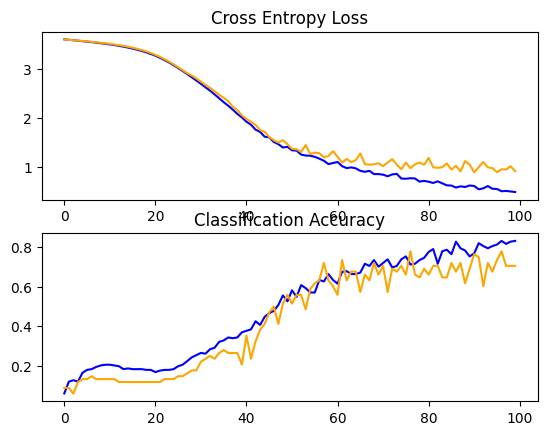

In [ ]:
import matplotlib.pyplot as plt

histories = list()
histories.append(history)

# plot diagnostic learning curves
def summarize_diagnostics(histories):
	for i in range(len(histories)):
		# plot loss
		plt.subplot(2, 1, 1)
		plt.title('Cross Entropy Loss')
		plt.plot(histories[i].history['loss'], color='blue', label='train')
		plt.plot(histories[i].history['val_loss'], color='orange', label='test')
		# plot accuracy
		plt.subplot(2, 1, 2)
		plt.title('Classification Accuracy')
		plt.plot(histories[i].history['accuracy'], color='blue', label='train')
		plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')
	plt.show()

summarize_diagnostics(histories)